In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import re
import io
import matplotlib.pylab as plt
from fa2 import ForceAtlas2
import json
import ast
from collections import Counter
import pickle

In [2]:
g = nx.read_gpickle("directors_network.gpickle")

In [3]:
g.number_of_nodes()

2050

In [4]:
g.number_of_edges()

87674

In [5]:
degrees = g.degree()
list_degrees = sorted(degrees, key=lambda x: x[1], reverse=True)

In [6]:
print('Director who has actors in common with most directors',list_degrees[0][0])
print('Has actors in common with ' + str(list_degrees[0][1]) + ' different directors')

Director who has actors in common with most directors Steven Spielberg
Has actors in common with 901 different directors


In [7]:
list_degrees

[('Steven Spielberg', 901),
 ('Oliver Stone', 878),
 ('Tony Scott', 757),
 ('Ridley Scott', 737),
 ('Joel Schumacher', 723),
 ('Ron Howard', 697),
 ('Brian De Palma', 697),
 ('Clint Eastwood', 697),
 ('Francis Ford Coppola', 691),
 ('Robert Zemeckis', 684),
 ('Tim Burton', 667),
 ('Woody Allen', 655),
 ('Barry Levinson', 655),
 ('Robert Altman', 642),
 ('Martin Scorsese', 636),
 ('Ivan Reitman', 608),
 ('Michael Bay', 607),
 ('Wolfgang Petersen', 590),
 ('Michael Mann', 579),
 ('Richard Donner', 574),
 ('John McTiernan', 570),
 ('David Fincher', 541),
 ('Joe Dante', 524),
 ('Andrew Davis', 522),
 ('Steven Soderbergh', 522),
 ('Rob Reiner', 517),
 ('Renny Harlin', 514),
 ('Phillip Noyce', 513),
 ('Joel Coen', 513),
 ('Wes Craven', 512),
 ('Spike Lee', 511),
 ('Barry Sonnenfeld', 510),
 ('Roland Emmerich', 506),
 ('Chris Columbus', 505),
 ('Walter Hill', 499),
 ('Philip Kaufman', 497),
 ('Cameron Crowe', 488),
 ('Sydney Pollack', 488),
 ('James Cameron', 486),
 ('Terry Gilliam', 483),
 (

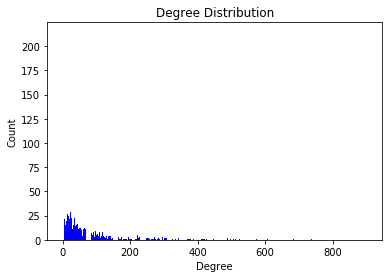

In [8]:
degree_sequence = sorted([d for n, d in g.degree()], reverse=True)
degreeCount = Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Distribution")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

In [9]:
gc= max(nx.connected_component_subgraphs(g), key=len)
gc

In [10]:
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=True,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=2.0,
                          strongGravityMode=False,
                          gravity=1.0,

                          # Log
                          verbose=True)

In [11]:
# Takes a few minutes to run
positions = forceatlas2.forceatlas2_networkx_layout(gc, pos=None, iterations=5000)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [06:05<00:00, 13.70it/s]


BarnesHut Approximation  took  30.08  seconds
Repulsion forces  took  321.49  seconds
Gravitational forces  took  0.62  seconds
Attraction forces  took  6.04  seconds
AdjustSpeedAndApplyForces step  took  2.71  seconds


D:\Programs\Anaconda\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


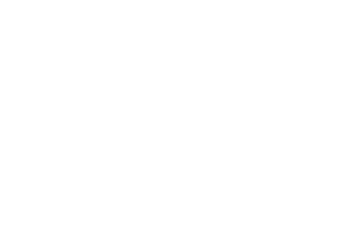

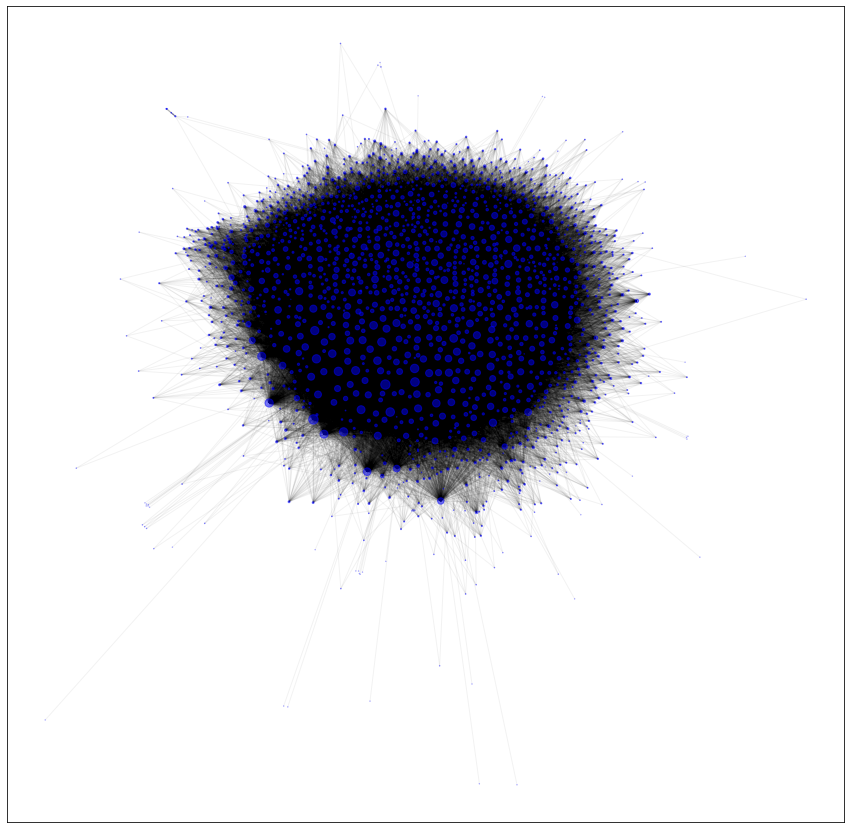

In [15]:
d = dict(gc.degree)
degrees = [(d[node])/10 for node in gc.nodes()]
plt.axis('off')
plt.figure(figsize=(15,15)) 
nx.draw_networkx_nodes(gc, positions ,node_color='blue', node_size= degrees, with_labels=False, alpha=0.5)
nx.draw_networkx_edges(gc, positions, alpha=0.05)
plt.savefig('demo.png', transparent=True)
plt.show()

<Figure size 432x288 with 0 Axes>